In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yotam hermon\Anacond

In [2]:
#setting up the GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [1]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
# my computer count is 1 GPU and 8 core for CPU, please note, if your machine is not contatining GPU or different core count 
# the code will not work

NameError: name 'tf' is not defined

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output 
x=GlobalAveragePooling2D()(x) # we will use an average pooling method
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [2]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True
# at this point we choose the training depth, mobile net contatining 88 layers, by choosing 20 first layers to be non train able
# we are setting the first 20 layers to be non trainable 

NameError: name 'model' is not defined

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)


Found 2970 images belonging to 2 classes.


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)


Epoch 1/5
92/92 [==============================] - 13s 146ms/step - loss: 0.5039 - accuracy: 0.8278
Epoch 2/5
92/92 [==============================] - 10s 109ms/step - loss: 0.3802 - accuracy: 0.8417
Epoch 3/5
92/92 [==============================] - 10s 109ms/step - loss: 0.3319 - accuracy: 0.8509
Epoch 4/5
92/92 [==============================] - 10s 110ms/step - loss: 0.2995 - accuracy: 0.8724
Epoch 5/5
92/92 [==============================] - 10s 110ms/step - loss: 0.2595 - accuracy: 0.8965


In [10]:
print (model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [11]:
def validation(model, train_datagen):
    #model=Model(inputs=base_model.input,outputs=preds)
    #model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    val_generator=train_datagen.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

    step_size_val=val_generator.n//val_generator.batch_size
    history1 = model.fit_generator(generator=val_generator,
                       steps_per_epoch=step_size_val,
                       epochs=5)
    return history1

In [12]:
history1 = validation(model,train_datagen)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 1s 293ms/step - loss: 1.7835 - accuracy: 0.5455
Epoch 2/5
3/3 [==============================] - 0s 110ms/step - loss: 0.5429 - accuracy: 0.7396
Epoch 3/5
3/3 [==============================] - 0s 101ms/step - loss: 0.5560 - accuracy: 0.7955
Epoch 4/5
3/3 [==============================] - 0s 102ms/step - loss: 0.5181 - accuracy: 0.7045
Epoch 5/5
3/3 [==============================] - 0s 102ms/step - loss: 0.3642 - accuracy: 0.8864


In [15]:
base_model2=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model2.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model2=Model(inputs=base_model2.input,outputs=preds)

for layer in model2.layers[:20]:
    layer.trainable=False
for layer in model2.layers[20:]:
    layer.trainable=True

train_datagen2=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_noise=train_datagen2.flow_from_directory('../data/train/noised_spectrogram/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_noise=train_generator_noise.n//train_generator_noise.batch_size
history2 = model2.fit_generator(generator=train_generator_noise,
                   steps_per_epoch=step_size_noise,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 1697 images belonging to 2 classes.
Epoch 1/5
53/53 [==============================] - 8s 142ms/step - loss: 0.5145 - accuracy: 0.8078
Epoch 2/5
53/53 [==============================] - 6s 108ms/step - loss: 0.4017 - accuracy: 0.8168
Epoch 3/5
53/53 [==============================] - 6s 110ms/step - loss: 0.3498 - accuracy: 0.8390
Epoch 4/5
53/53 [==============================] - 6s 109ms/step - loss: 0.2710 - accuracy: 0.8883
Epoch 5/5
53/53 [==============================] - 6s 112ms/step - loss: 0.2166 - accuracy: 0.9098


In [16]:
history_noisedVal = validation(model2,train_datagen2)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 109ms/step - loss: 1.2133 - accuracy: 0.4886
Epoch 2/5
3/3 [==============================] - 0s 109ms/step - loss: 0.6493 - accuracy: 0.5341
Epoch 3/5
3/3 [==============================] - 0s 118ms/step - loss: 0.5855 - accuracy: 0.7083
Epoch 4/5
3/3 [==============================] - 0s 101ms/step - loss: 0.4665 - accuracy: 0.7273
Epoch 5/5
3/3 [==============================] - 0s 101ms/step - loss: 0.4104 - accuracy: 0.8523


In [17]:
base_model3=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model3.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model3=Model(inputs=base_model3.input,outputs=preds)

for layer in model3.layers[:20]:
    layer.trainable=False
for layer in model3.layers[20:]:
    layer.trainable=True

train_datagen3=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_timeshift=train_datagen3.flow_from_directory('../data/train/time_shift_spectrogram/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_timeshift=train_generator_timeshift.n//train_generator_timeshift.batch_size
history3 = model3.fit_generator(generator=train_generator_timeshift,
                   steps_per_epoch=step_size_timeshift,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 1697 images belonging to 2 classes.
Epoch 1/5
53/53 [==============================] - 7s 137ms/step - loss: 0.6233 - accuracy: 0.7946
Epoch 2/5
53/53 [==============================] - 6s 109ms/step - loss: 0.4960 - accuracy: 0.8144
Epoch 3/5
53/53 [==============================] - 6s 109ms/step - loss: 0.4698 - accuracy: 0.8246
Epoch 4/5
53/53 [==============================] - 6s 110ms/step - loss: 0.4785 - accuracy: 0.8132
Epoch 5/5
53/53 [==============================] - 6s 110ms/step - loss: 0.4735 - accuracy: 0.8192


In [18]:
history_timeshiftVal = validation(model3,train_datagen3)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 111ms/step - loss: 0.7919 - accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 0s 109ms/step - loss: 0.6888 - accuracy: 0.5000
Epoch 3/5
3/3 [==============================] - 0s 117ms/step - loss: 0.6641 - accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 0s 104ms/step - loss: 0.6166 - accuracy: 0.5114
Epoch 5/5
3/3 [==============================] - 0s 119ms/step - loss: 0.4460 - accuracy: 0.8021


In [19]:
base_model4=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model4.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model4=Model(inputs=base_model4.input,outputs=preds)

for layer in model4.layers[:20]:
    layer.trainable=False
for layer in model4.layers[20:]:
    layer.trainable=True

train_datagen4=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_snp=train_datagen4.flow_from_directory('../data/train/pepper_and_sault_spectrogram/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model4.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_snp=train_generator_snp.n//train_generator_snp.batch_size
history4 = model4.fit_generator(generator=train_generator_snp,
                   steps_per_epoch=step_size_snp,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 1283 images belonging to 2 classes.
Epoch 1/5
40/40 [==============================] - 6s 160ms/step - loss: 0.4950 - accuracy: 0.8617
Epoch 2/5
40/40 [==============================] - 4s 111ms/step - loss: 0.2680 - accuracy: 0.8719
Epoch 3/5
40/40 [==============================] - 5s 114ms/step - loss: 0.1641 - accuracy: 0.9361
Epoch 4/5
40/40 [==============================] - 4s 112ms/step - loss: 0.2732 - accuracy: 0.9288
Epoch 5/5
40/40 [==============================] - 4s 110ms/step - loss: 0.1603 - accuracy: 0.9440


In [20]:
history_snpVal = validation(model4,train_datagen4)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 110ms/step - loss: 1.2397 - accuracy: 0.5227
Epoch 2/5
3/3 [==============================] - 0s 115ms/step - loss: 0.5590 - accuracy: 0.6771
Epoch 3/5
3/3 [==============================] - 0s 111ms/step - loss: 0.4863 - accuracy: 0.6932
Epoch 4/5
3/3 [==============================] - 0s 102ms/step - loss: 0.3354 - accuracy: 0.8295
Epoch 5/5
3/3 [==============================] - 0s 117ms/step - loss: 0.3409 - accuracy: 0.8229


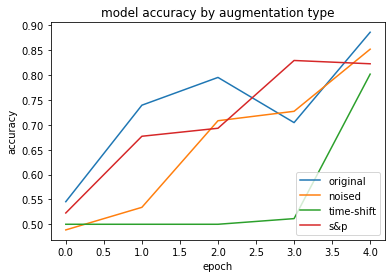

In [21]:
plt.plot(history1.history['accuracy'])
plt.plot(history_noisedVal.history['accuracy'])
plt.plot(history_timeshiftVal.history['accuracy'])
plt.plot(history_snpVal.history['accuracy'])
plt.title('model accuracy by augmentation type')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['original', 'noised', 'time-shift','s&p'], loc='lower right')
plt.show()

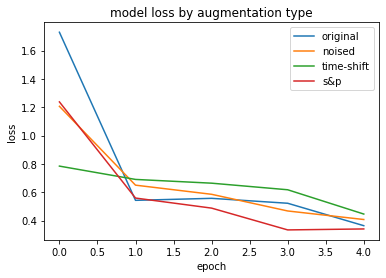

In [22]:
plt.plot(history1.history['loss'])
plt.plot(history_noisedVal.history['loss'])
plt.plot(history_timeshiftVal.history['loss'])
plt.plot(history_snpVal.history['loss'])
plt.title('model loss by augmentation type')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['original', 'noised', 'time-shift','s&p'], loc='upper right')
plt.show()